# PyTorch mutual information neural estimation tests

Trivial tests with multivariate Gaussian and uniform distribution

In [1]:
import sys
sys.path.append("../python")

In [2]:
import numpy as np

In [3]:
import torch
import torchkld
import mutinfo

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda
Devices count: 2


In [5]:
from tqdm import tqdm, trange

In [6]:
from mutinfo.distributions.base import *

In [7]:
from misc.modules import *
from misc.plots import *

## Dataset

Experimental setup

In [8]:
mutual_information = 10.0

dataset_type = "uniform"
assert dataset_type in ["normal", "uniform", "smoothed_uniform", "Student", "Student_arcsinh"]

dimension = 32

In [9]:
if dataset_type == "normal":
    random_variable = CorrelatedNormal(mutual_information, dimension, dimension, randomize_correlation=False)
    
elif dataset_type == "uniform":
    random_variable = CorrelatedUniform(mutual_information, dimension, dimension, randomize_correlation=False)

elif dataset_type == "smoothed_uniform":
    random_variable = SmoothedUniform(mutual_information, dimension, dimension, randomize_smoothing_epsilon=False)

In [12]:
n_samples = 10*1024
x, y = random_variable.rvs(n_samples)

## Estimating MI

In [14]:
batch_size = 1024
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x, dtype=torch.float32),
    torch.tensor(y, dtype=torch.float32),
    torch.tensor(x[np.random.permutation(x.shape[0])], dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
model = BasicDenseT(dimension, dimension, inner_dim=100).to(device)

In [16]:
# Training parameters.
#loss = torchkld.loss.NishiyamaLoss()
#loss = torchkld.loss.DonskerVaradhanLoss(biased=False, ema_multiplier=1e-2)
loss = torchkld.loss.DonskerVaradhanLoss(biased=True)
#loss = torchkld.loss.NWJLoss()

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
import matplotlib
from matplotlib import pyplot as plt

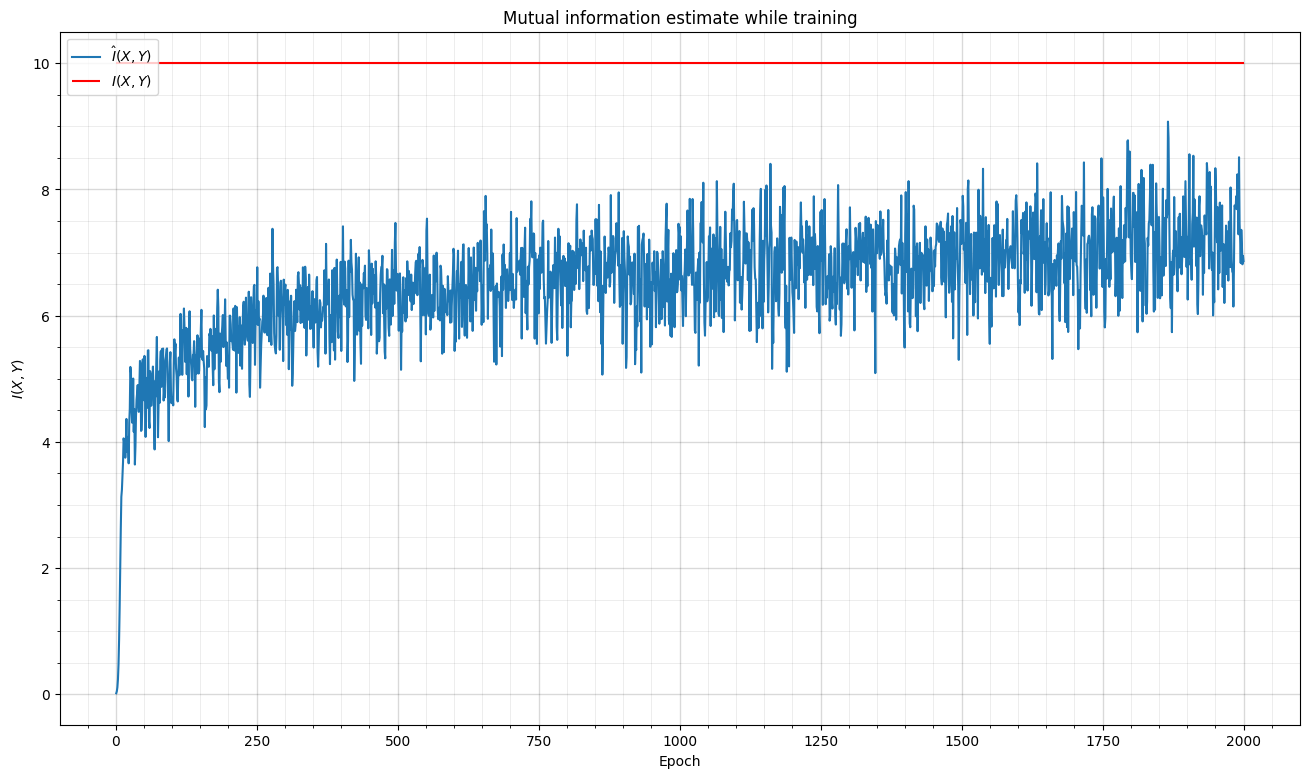

Current estimate: 6.86
Running median: 7.27


In [18]:
from IPython.display import clear_output
n_epochs = 2000

estimated_MI = []
for epoch in range(1, n_epochs + 1):    
    # Training.
    for index, batch in enumerate(dataloader):
        x, y, z = batch
        batch_size = x.shape[0]
        
        model.zero_grad()
        T_joined   = model(x.to(device), y.to(device))
        T_marginal = model(x.to(device), y.to(device), marginalize=True)
        #T_marginal = model(x.to(device), y.to(device), marginalize="product")
        #T_marginal = model(z.to(device), y.to(device))
        _loss = loss(T_joined, T_marginal)
        _loss.backward()
        opt.step()
        
    estimated_MI.append(model.get_mutual_information(dataloader, loss, device))

    if epoch % 10 == 0:
        clear_output(wait=True)
        plot_estimated_MI_trainig(mutual_information, np.arange(1, epoch+1), estimated_MI)
        print(f"Current estimate: {estimated_MI[-1]:.2f}")
        print(f"Running median: {np.median(estimated_MI[-100:]):.2f}")